In [ ]:
!pip install stop_words
!pip install treelib

  Created wheel for treelib: filename=treelib-1.6.1-py3-none-any.whl size=18386 sha256=d2ee1f8b0b6a99f85665592cc7bc4cb6ce3b2d5bfda9ab92932d94f4afdb8f27
  Stored in directory: /root/.cache/pip/wheels/89/be/94/2c6d949ce599d1443426d83ba4dc93cd35c0f4638260930a53
Successfully built treelib


In [ ]:
import nltk
import pandas as pd
from stop_words import get_stop_words
import numpy as np
import random
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import requests
import datetime as dt
import time 
import re
from gensim.models import Word2Vec
from numpy import dot
from numpy.linalg import norm
import math
from sklearn.metrics.pairwise import cosine_similarity
from treelib import Node, Tree
import plotly.express as px
from dateutil import parser
import plotly.graph_objects as go

In [ ]:
# Load word2vec model (trained on an enormous Google corpus). You would need to download this yourself and run it, as it's a large file
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 

In the following block of code, we access our dataset, and then randomly access the indices of 80% of the headlines to form our dataset vocabulary, hoping it'll give us a general picture of the average vocabulary used. Not sure if this step is needed, in which case we can modify it starting at the  variable 'data'.

In [ ]:
#model = Word2Vec.load("word2vec.model")

In [ ]:
#model.most_similar("coronavirus")

In [ ]:

# model = Word2Vec(all_words, min_count = 2)
#model.get_vector('biden')

In [ ]:
def getAverageVector(headline):

  headline = re.sub('[^a-zA-Z]', ' ', headline )
  headline = re.sub(r'\s+', ' ', headline)
  
  input_headline = headline
  array = np.zeros([300])
  n = 0
  for word in nltk.word_tokenize(input_headline):
    try:
      array += model.get_vector(word.lower())
      n += 1
    except:
      pass
  array = array/max(n,1)
  return array

In [ ]:
array_1 = getAverageVector("SCOTUS Rules Police Cannot biden Search Homes Without Warrants in the Name of 'Community Caretaking'")

In [ ]:
array_2 = getAverageVector("SCOTUS Rules Trump police Cannot Search Buildings'")

In [ ]:
print("the similarity between sentences:") 
print("\"SCOTUS Rules Police Cannot biden Search Homes Without Warrants in the Name of 'Community Caretaking'\"")
print( "and \"SCOTUS Rules Trump Police Cannot Search Buildings'\" is ")

print(cosine_similarity(np.matrix(array_1),np.matrix([array_2]))[0,0])

the similarity between sentences:
"SCOTUS Rules Police Cannot biden Search Homes Without Warrants in the Name of 'Community Caretaking'"
and "SCOTUS Rules Trump Police Cannot Search Buildings'" is 
0.7832679794980949


We try converting headline array into a list containing sentences for the sent2vec approach.

In [1]:
X = pd.read_csv('merged_training.csv')
X

NameError: ignored

In [ ]:
news_dates = np.matrix(X.iloc[:,5:11])
news_vectors = np.matrix(X.iloc[:,11:311])  
dmy = np.matrix(X.iloc[:,5:8])#this just contains the days, months,years of each news article

In [ ]:
def date_index(Y):
  """ ex: given news minute, month, year, returns dict = {(month, day, year):  i }, where i is the index in which this event occurs """
  date_and_index = {} #Short for Dictionary/Wiki
  date_and_index[tuple(list(np.array(Y[0])[0]))] = 0
  for i in range(len(Y)-1):
    if Y[i,1] != Y[i+1,1]:
      date_and_index[tuple(list(np.array(Y[i+1])[0]))] =i+1  
  return date_and_index

In [ ]:
np.array(dmy[0])[0]

array([   4,   21, 2021])

In [ ]:
date_dictionary = date_index(dmy) #Dictionary containing Date and associated index in the csv file.
#date_dictionary 

In [ ]:
#date_dictionary

We construct a function that we will use to reorder the news vectors so that the newer news-vectors come first.

In [ ]:
def from_new_to_old(matrix):
    # suppose the matrix is an nxm matrix
    n = matrix.shape[0]
    m = matrix.shape[1]
    A = np.zeros([n,m])
    for i in range(n):
        A[i] = matrix[n-i-1]
    return A

In [ ]:
(4,12,2020)[0]

4

In [ ]:
def start_date_funct(end_date, date_wiki,matrix):
    days =  list(date_wiki.keys())
    add_one_day = tuple(np.array(end_date) - np.array([0,1,0]))
    add_one_month = tuple(np.array(end_date) - np.array([1,0,0]))
#    add_one_month = tuple(end_date[0],)
    add_one_year = tuple(np.array(end_date) - np.array([0,0,1]))
    if add_one_day in days:
        return date_wiki[add_one_day]-1
    elif (end_date[0]-1,31,end_date[2])  in days:
        return date_wiki[(end_date[0]-1,31,end_date[2])]-1
    elif (end_date[0]-1,30,end_date[2])  in days :
        return date_wiki[(end_date[0]-1,30,end_date[2])]-1
    elif (end_date[0]-1,29,end_date[2])  in days :
        return date_wiki[(end_date[0]-1,29,end_date[2])]-1 
    elif (end_date[0]-1,28,end_date[2])  in days :
        return date_wiki[(end_date[0]-1,29,end_date[2])-1]-1     
    #In case the end date is not in there, we add the news article
    elif np.max(np.array(end_date)- np.array(dmy[0])[0]) == 0:
        return date_wiki[ end_date ]
    else:
        return date_wiki[(12,31,end_date[2]-1)]-1

Below is an outdate function sim_matrix, more efficient one is s_m. constructs matrix full of similarity scores.

In [ ]:
def sim_matrix(end_date, start_date, date_wiki, news_vector):
  # we order the news articles so that the newer news articles 
#in the specified time_period come first in the matrix, older articles come last
    news_matrix = from_new_to_old(news_vector[date_wiki[end_date]:start_date_funct(start_date,date_wiki,news_vector) ]) 
    N = len(news_matrix)
  #we construct an empty matrix
    A = np.zeros([N,N])
#for every news article i
    for i in range(N):
#we want to see similar it to older news articles in the specifed time interval
#so we look at news articles j = i+1,i+2,... n in our matrix
        for j in range(i+1,N):
            A[i,j] = cosine_similarity(np.matrix(news_matrix[i]),  np.matrix(news_matrix[j]))
    return A

In [ ]:
def s_m(end_date, start_date, date_wiki, news_vector):
    """Returns an upper triangular matrix that denotes news article i and the similarity of all news articles to come after it """
    M = news_vectors[date_dictionary[end_date]:start_date_funct(start_date,date_dictionary,news_vectors)]
    A=cosine_similarity(from_new_to_old(M),from_new_to_old(M))
    A = np.round(np.triu(A)- np.diag(np.ones([len(A)]),k=0),5)
    return A

In [ ]:
#list(date_dictionary.keys())

In [ ]:
matrix_2 = s_m((2,29,2020), (2,24,2020),date_dictionary, news_vectors)
matrix_2

array([[ 0.     ,  0.44   ,  0.37071, ...,  0.35835,  0.4625 ,  0.47509],
       [ 0.     , -0.     ,  0.44246, ...,  0.40719,  0.48059,  0.43786],
       [ 0.     ,  0.     ,  0.     , ...,  0.36312,  0.42957,  0.32463],
       ...,
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.37377,  0.32216],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.57158],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     , -0.     ]])

### Below is just some visual sample testing of similarity of news articles, can ignore. 

In [ ]:

def s_2_a(X):#similarity matrix to set of arrays. I use this function to plot the similarity scores for each news article below.
  """ I use this to not consider the 0's below the diagonal of the matrix when I plot the similarity scores"""   
  N = len(X[0])
  a = []
  for i in range(N-1):
    a.append(X[i,i+1:])
  return a

data_points =  s_2_a(matrix_2)


Text(0, 0.5, 'similarity-score for subsequent articles')

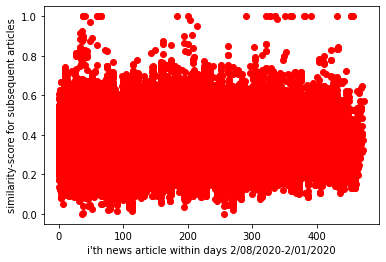

In [ ]:
import matplotlib.pyplot as plt
for k in range(len(matrix_2)-1):
    x = [k+1 for i in range(len(data_points[k]))]
#    print(x)
    plt.plot(x, data_points[k],'ro')
plt.xlabel('i\'th news article within days 2/08/2020-2/01/2020')
plt.ylabel('similarity-score for subsequent articles')

From here we can notice that there aren't that many news articles with similarity scores above 0.6. We will use this to represent events in the form of trees. We also want to prevent the problem below. 

In [ ]:
tree = Tree()
tree.create_node("News headline 1", "nh1")  # root node
tree.create_node("News headline 2", "nh2", parent="nh1")
tree.create_node("News headline 4", "nh4", parent="nh1")
tree.create_node("News headline 3", "nh3", parent="nh2")
tree.create_node("News headline 3", "nh5", parent="nh1")
tree.create_node("News headline 4", "nh6", parent="nh3")
print("\u0332".join("Event 1"))
tree.show()

E̲v̲e̲n̲t̲ ̲1
News headline 1
├── News headline 2
│   └── News headline 3
│       └── News headline 4
├── News headline 3
└── News headline 4



In [ ]:
def sim_dict(sim_matrix, cutoff, start_date, date_wiki,news_vec):
    start_index = start_date_funct(start_date,date_wiki,news_vec) # we know what index we are going to start our dictionary at.
    event_dict = {}
    score_dict = {}    
    for i in range(len(sim_matrix)-1):
    #we are looking at news article start_index+i, and the corresponding similarity scores with the news articles j
        l = []
        s = []
        for j in range(i+1, len(sim_matrix)):
          # if the similarity scores are >= our cutoff, we store them in variable l
          if sim_matrix[i,j] >= cutoff and sim_matrix[i,j] < 0.95:
            l.append(start_index- j-1)
            s.append(sim_matrix[i,j]) 
            # we start
            #now news article start_index + i can see the news articles after it
            event_dict[ start_index-i-1] = l
            score_dict[ start_index-i-1] = s
    return event_dict, score_dict

In [ ]:
def rem_dead_events(event_dict):
  """idea is to remove news articles with no incoming edge nor outgoing edge"""
  reduced = event_dict 
  list_of_lists = reduced.values()
  # the values in the event dictionary are news article indices, some 
  # of which repeat. We want to prevent repetition, and construct a list
  # of news articles that have an incoming edge
  l = []
  for i in list_of_lists:
    l+=i
  l = list(set(l))
  keys = list(reduced.keys())
  for i in range(len(keys)):
    if len(reduced[keys[i]])== 0 and keys[i] not in l:
      reduced.pop(keys[i])
  return reduced

In [ ]:
def pre_process_array(event_dict):
  """given a news article i This function looks at the other news articles that
  came out after news article i that news article i is similar to, say news 
  article j and removes the news articles that they have in common"""
  key = list( event_dict.keys())
  z = event_dict
  for i in range(len(key)):
    initial_nodes = event_dict[key[i]]
    temp_list = initial_nodes
    if len(temp_list) >=1:
      for j in range(len(temp_list)):
        try:
            child_nodes = event_dict[temp_list[j]]
            initial_nodes = list(set(initial_nodes).difference(child_nodes))
            z[key[i]] = initial_nodes
        except:
            pass
  return z
#r = pre_process_array(r)


In [ ]:
def process_array(sim_matrix, cutoff, start_date, date_wiki,news_vec):
    event_dict = sim_dict(sim_matrix,cutoff, start_date,date_wiki,news_vec)[0]
    event_dict = rem_dead_events(event_dict)
    return pre_process_array(event_dict)

let r_1 and r_2 denote event dictionarys from 2/27/2020-3/4/2020 and 3/5/2020 - 3/15/2020

In [ ]:
matrix_2 = s_m((3,4,2020), (2,27,2020),date_dictionary, news_vectors)
r1 = process_array(matrix_2,0.79, (2,27,2020),date_dictionary,news_vectors)
matrix_3 = s_m((3,15,2020), (3,5,2020),date_dictionary, news_vectors)
r2 = process_array(matrix_3,0.79, (3,5,2020),date_dictionary,news_vectors)

In [ ]:
len(list(r1.keys())+list(r2.keys()))

203

tree.create_node(X.iloc([33361,1]),33361)

In [ ]:
def unique_events(event_dict):
    """If we assume each event can be represented as a tree, returns the roots of all the event trees """
    unique_val = []
    keys = list(event_dict.keys())
    reduced = event_dict 
    list_of_lists = reduced.values()
    l = []
    for i in list_of_lists:
        l+=i
    l = list(set(l))
    for i in range(len(keys)):
        if keys[i] not in l:
            unique_val.append(keys[i])
    return unique_val

In [ ]:
def getChildNode(key,r):
    """Given a parent or root node, constructs child nodes"""
    for val in r[key]:
        try:
            tree.create_node(X.iloc[val,1], val, parent = key)
            getChildNode(val,r)
        except:
            pass


In [ ]:
def getInd(key,r):
    """Given a key, returns all the news articles related to that key"""
    i_list = [key]
    def getIndNodes(key,r):
        for val in r[key]:
            try:
                i_list.append(val)
                return getIndNodes(val,r)
            except:
                pass
    getIndNodes(key,r)
    return i_list

In [ ]:
def get_centroid(key,r):
    """Given a unique event, this returns the centroid for that event"""
    #here we are going to use the key associated with an event
    i_list = [key]
    vec = np.matrix(np.zeros([300]))
    # we construct a function that gets all the indices associated with an event.
    # we get the indices associated with an event
    i_list+= getInd(key,r)
    # we now sum of every vector in an event
    for i in i_list:
        vec+= news_vectors[i]
    # we return the centroid
    return vec/len(i_list)

In [ ]:
def ind_to_matrices(keys,news_vectors):
    """takes a list of keys and returns their news vectors in row form of a matrix"""
    X = np.zeros([len(keys),news_vectors.shape[1]])
    for i in range(len(keys)):
        X[i] = news_vectors[keys[i]]
    return X

In [ ]:
def centroid_matrix(events1,events2):
    set1 = unique_events(events1)
    set2 = unique_events(events2)
    """with respect to time, event 1 has to come before event 2"""
    centroid = np.zeros([300,1])
    m = len(set1)
    n = len(set2)
    A = np.zeros([m,n])
    #if there are m events in events1, n events in events 2
    # we check if the centroids associated with each event are very similar,
    # if they are very similar, then we will attach the event in event2
    # to the most similar news article in event 1
    for i in range(m):
        for j in range(n):
            A[i,j] = cosine_similarity(get_centroid(set1[i],events1), get_centroid(set2[j] ,events2 ))
    return A

In [ ]:
def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [ ]:
def lists2list(List):
    l= []
    for i in list(List):
        l+=i
    return l

In [ ]:
def connect_events(events1,events2,s_score):
    """This function is currently broken, it's supposed to connect events in event dictionary 2 to event dictionary 1"""

    def Merge(dict1, dict2):
        res = {**dict1, **dict2}
        return res
    #Get roots for each unique event
    set1 = unique_events(events1)
    set2 = unique_events(events2)
    #with respect to time, event 1 has to come before event 2
    centroid = np.zeros([300,1])
    m = len(set1)
    n = len(set2)
    new_dict = {}
    # we create a dictionary with the events in event 1
    new_dict = Merge(new_dict,events1)
    #for events in event dictionary 1, we take a look at events in event 2, and if they are similar to 
    #centroids events in event dictionary 1, combine the root of event in event 2 to the most similar
    # news article in the event 1
    for i in range(m):
        for j in range(n):
            if cosine_similarity(get_centroid(set1[i],events1), get_centroid(set2[j] ,events2 )) >= s_score:
                nodes_similarity = cosine_similarity(news_vectors[set2[j]], ind_to_matrices(getInd(set1[i],events1),news_vectors))
                node_to_attach = getInd(set1[i],events1)[np.argmax(nodes_similarity,axis = 1)[0]] 
                new_dict[node_to_attach] = new_dict[node_to_attach]+[set2[j]]
# otherwise, we just add the events in event 2.
    for event in set2:
        if events not in list(new_dict.keys()) or events not in lists2list(new_dict.values()):
                temp = getInd(event, events2)
                for i in temp:
                    new_dict[i] = events2[i]
    for key in new_dict.keys():
        new_dict[key] = list(set(new_dict[key]))
    return new_dict

In [ ]:
#conn = connect_events(r1,r2,0.79)
conn = r1
#conn

In [ ]:
def e2t(e,m):
    """Stores events in event_dictionary into a list of trees with pandas dataset, whereby each tree is an event"""
    events = unique_events(e)
    L = []
    for i in events:
        tree = Tree()
        # create function inside here to manipulate tree directly using recursion
        def getChildNode(key,r):
            for val in r[key]:
                try:
                    tree.create_node(X.iloc[val,1], val, parent = key)
                    getChildNode(val,r)
                except:
                    pass
        tree.create_node(m.iloc[i,1], i)
        getChildNode(i,e)
        L.append(tree)
    return L

In [ ]:
def get_key(val,dic):
    """ function to return key for any values in an event dictionary"""
    for key, value in dic.items():
         if value.count(val)>0:
            return key
    return "key doesn't exist"


In [ ]:
temp = e2t(conn,X)
for i in range(len(temp)):
    temp[i].show()

Harry warned 'doors will be closing' for him and Meghan Markle after Royal Family exit | Royal | News
└── Prince Harry Reunites with the Queen for Lunch as He and Meghan Markle Prepare Their Royal Exit

Stocks enter correction, Dow plunges 500 points, as coronavirus fears multiply
├── Dow Jones falls another 500 points as coronavirus fears grow
│   └── Dow falls 800 points as coronavirus fears smash Wall Street
│       └── Dow plunges another 1,000 points due to coronavirus fears
└── Dow Jones falls another 500 points as coronavirus fears grow

Weber County Jail inmates escapes by posing as other inmate
└── Utah prisoner escapes jail after shaving head, posing as inmate who was set to be freed, police say

Denmark sees first coronavirus case in man returning from Italy vacation
└── Lebanon registers third case of coronavirus after man returns from Iran

You now have a claim to a stock like Apple, Ford, or Facebook. In order to keep this claim to your stock, sign up and join Robinhood u

In [ ]:
#cosine_similarity(np.matrix([getAverageVector("Brazilian official who met Trump testing for coronavirus")]),np.matrix([getAverageVector("Trump was with Brazilian president last week who has tested positive for Coronavirus ")]))

In [ ]:
def reverse_dict(event_dict):
    """Returns root news article  that  every subsequent news article is associated to """
    simp_event = {}
    ue = unique_events(event_dict)
    for event in ue:
        simp_event[event] = getInd(event,event_dict)[1:]   
    rd = {}
    v = list(simp_event.values())
    val = []
    for i in range(len(v)):
        val+= v[i]
    val = list(set(val))
    for i in range(len(val)):
        rd[val[i]] = get_key(val[i],simp_event)
    return rd

In [ ]:
def event_class(event_dict):
    """This generates a class label for all the events in the event_dictionary"""
    misc_dict = {}
    #we get the list of unique events
    events = unique_events(event_dict)
    # since the df goes from newest to newest, the largest index is of the earliest event
    events.sort(reverse=True)
    #we label each event
    for i in range(len(events)):
         misc_dict[events[i]] =  "event " + str(i+1)
    #We create a a dictionary that associates each news article to an event        
    d = {**reverse_dict(event_dict)}
    #we check each news article in the dictionary key
    # and give them a class label
    for mkey in misc_dict.keys():
        for key in d.keys():
            if d[key] == mkey:
                d[key] = misc_dict[mkey]
    
    return Merge(d,misc_dict)

In [ ]:
def extract_articles(event_dict):
    """just creates of list of all the unique news articles from the list of news articles in the event dictionary"""
    articles = []
    for article in event_dict.values():
        articles+= article
    return list(set(articles))

Note that for us to chart the desired graph, we need to convert the time of the stock prices into an date-time object, as done below:

In [ ]:
SPY_DS = pd.read_csv('PRICES_DATASET_SPY.csv')
time2 = [parser.parse(x)+ dt.timedelta(hours = 4)for x in SPY_DS["Time"]]
SPY_DS["Time"] = time2

In [ ]:
def chart(DF,t_col,p_col,event_dictionary): 
    """Need to enter the dataframe DF which is the minute by minute stock prices containing chosen time period,
    t_col is the time each news article came out,p_col is the stock price the moment each news article came out,
    event_dictionary is self-explanatory"""
    Time = t_col
    event_d = event_class(event_dictionary)
    hm = unique_events(conn) + extract_articles(event_dictionary)
    hn = list(event_d.keys()) + unique_events(event_dictionary)
    #hm contains list of all news articles in our dictionary
    #construct array x_d for time for each news article
    x_d= [parser.parse(Time[i]) for i in hm and list(event_d.keys())]

    Price = p_col
    #array y_d is the stock price the moment that each news article came out
    y_d = [Price[i] for i in hm and list(event_d.keys())]
    #z_d is the class label for each news headline
    z_d = [event_d[key] for key in hm and list(event_d.keys())]
    #h_d is the headline
    h_d = [X.iloc[i,1] for i in hm and list(event_d.keys())] 
    #We construct a dataframe
    df = pd.DataFrame(x_d,columns=['time'])
    df['price'] = y_d
    df['Event'] = z_d
    df['headline']=h_d
    # we gather the time interval that the events were occuring in
    min_x = min(x_d)
    max_x = max(x_d)
    #we get the minute by minute prices for the stocks in the price interval.
    S = DF[DF["Time"]>=min_x ]
    S = S[S["Time"]<= max_x]
    fig = go.Figure([go.Scatter(mode = "markers",x = x_d, y =y_d,hovertext = h_d )])
    fig = px.scatter(df,x = 'time', y ='price',color='Event',hover_data=["headline"],title = "S&P 500" )
    fig.add_trace(go.Scatter(x = S['Time'],y= S['Open'],marker = dict(color = "lightgray")))
    fig.update_layout(hovermode = 'x')
    return fig

we plot the chart according to event dictionary r1

In [ ]:
fig = chart(SPY_DS, X["timestampUTC"], X["1m"],r1)
fig.show()

In [ ]:
z =chart(SPY_DS, X["timestampUTC"], X["1m"],r1).to_json

In [ ]:
fig.write_html("istonk.html")

### Below is just the code above in it's original form (You can ignore ):

Time = X["timestampUTC"]
#event_clas = [ misc_dict[key] for key in unique_events(conn)]
event_d = event_class(conn)
hm = unique_events(conn) + extract_articles(conn)
hn = list(event_d.keys()) + unique_events(conn)
#hm contains list of all news articles in our dictionary
x_d= [parser.parse(Time[i]) for i in hm and list(event_d.keys())]
Price = X["1m"]
y_d = [Price[i] for i in hm and list(event_d.keys())]
z_d = [event_d[key] for key in hm and list(event_d.keys())]
h_d = [X.iloc[i,1] for i in hm and list(event_d.keys())]

df = pd.DataFrame(x_d,columns=['time'])
df['price'] = y_d
df['Event'] = z_d
df['headline']=h_d


min_x = min(x_d)
max_x = max(x_d)


S = SPY_DS[SPY_DS["Time"]>=min_x ]
S = S[S["Time"]<= max_x]
S

fig = px.scatter(df,x = 'time', y ='price',color='Event',hover_data=["headline"],title = "S&P 500" )

fig.add_trace(go.Scatter(x = S['Time'],y= S['Open'],marker = dict(color = "lightgray")))
fig.update_layout(hovermode = 'x')
#fig.update_layout(hovermode="x unified")